# 数字識別AIをつくろう


In [2]:
import torch
import torchvision

In [29]:
# 右上のランタイムの設定でT4を選択
# GPUが利用可能かを確認
torch.cuda.is_available()

True

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

# MNISTデータセットのダウンロードと変換
train_dataset = torchvision.datasets.MNIST(
    "./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    "./data", train=False, download=True, transform=transform
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.93MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



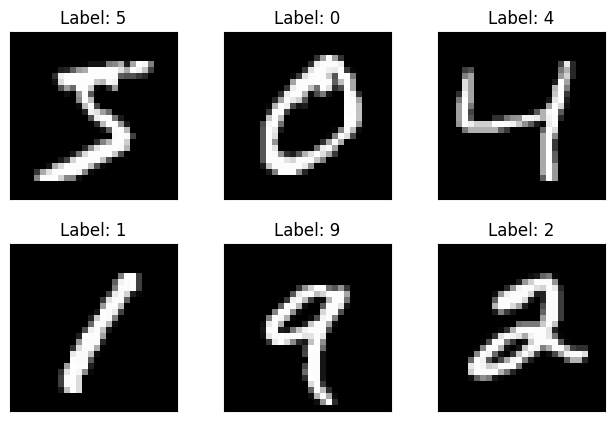

In [6]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    image_tensor = train_dataset[i][0]
    # 非正規化
    unnormalized_image = image_tensor / 2 + 0.5
    # (1, 28, 28) -> (28, 28, 1)
    permuted = unnormalized_image.permute(1, 2, 0)
    plt.imshow(permuted, cmap="gray")
    plt.title(f"Label: {train_dataset[i][1]}")
    plt.xticks([])
    plt.yticks([])

In [7]:
# データローダーの作成
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

print("各サンプル数")
print(len(train_loader.dataset))
print(len(test_loader.dataset))
print("各バッチ数")
print(len(train_loader))
print(len(test_loader))
print("各バッチサイズ（サンプル/バッチ）")
print(train_loader.batch_size)
print(test_loader.batch_size)

各サンプル数
60000
10000
各バッチ数
938
10
各バッチサイズ（サンプル/バッチ）
64
1000


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        # 親クラスのコンストラクタを呼び出す
        super(Net, self).__init__()
        # 畳み込み層の定義
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # ドロップアウトの定義
        self.conv2_drop = nn.Dropout2d()
        # 全結合層の定義
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, debug=False):
        if debug: print(f"入力データの次元: {x.shape}")

        x = self.conv1(x)
        if debug: print(f"畳み込み１層後: {x.shape}")
        x = F.max_pool2d(x, 2)
        if debug: print(f"プーリング１層後: {x.shape}")
        x = F.relu(x)

        x = self.conv2(x)
        if debug: print(f"畳み込み２層後: {x.shape}")
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        if debug: print(f"プーリング２層後: {x.shape}")
        x = F.relu(x)

        x = x.view(-1, 320)
        if debug: print(f"1次元テンソルに変換後: {x.shape}")
        x = self.fc1(x)
        if debug: print(f"全結合層１後: {x.shape}")
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        if debug: print(f"全結合層２後: {x.shape}")

        return F.log_softmax(x, dim=1)

Net()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [10]:
# パラメータの確認

# モデルのインスタンス化
model = Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"モデルのパラメータの場所: {next(model.parameters()).device}")

print("\n各層のパラメータ:")
total_params = 0
for name, param in model.named_parameters():
    print(f"{name}: {np.prod(param.size())}個 {param.device}に存在")
    total_params += param.numel()

print(f"\n合計パラメータ数: {total_params}個")

モデルのパラメータの場所: cuda:0

各層のパラメータ:
conv1.weight: 250個 cuda:0に存在
conv1.bias: 10個 cuda:0に存在
conv2.weight: 5000個 cuda:0に存在
conv2.bias: 20個 cuda:0に存在
fc1.weight: 16000個 cuda:0に存在
fc1.bias: 50個 cuda:0に存在
fc2.weight: 500個 cuda:0に存在
fc2.bias: 10個 cuda:0に存在

合計パラメータ数: 21840個


In [26]:
from torch.optim import SGD

def train(num_epochs=1, debug=False):
    model = Net().to(device)

    # 損失関数を定義
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.5)

    # ログ
    train_log_x = []
    train_log_y = []
    test_log_x = []
    test_log_y = []

    for epoch in range(num_epochs):
        if not debug: print(f"エポック: {epoch + 1}")
        for batch_index, (data, target) in enumerate(train_loader):
            # 勾配を計算すjる学習モードに設定
            model.train()

            # 勾配を初期化
            optimizer.zero_grad()

            # データをGPUに転送
            data, target = data.to(device), target.to(device)

            # モデルにデータを入力して予測を取得
            output = model(data, debug=debug)

            # 損失を計算
            loss = F.nll_loss(output, target)

            # 勾配を計算
            loss.backward()

            # パラメータの更新
            optimizer.step()

            # 100バッチごとに進捗を表示し、パラメータを保存
            if batch_index % 100 == 0 and not debug:
                data_num = batch_index * len(data)
                dataset_data_num = len(train_loader.dataset)
                total_trained = data_num + epoch * dataset_data_num
                train_log_x.append(total_trained)
                train_log_y.append(loss.item())
                print(f"バッチ:{batch_index}, データ:{data_num}/{dataset_data_num}, 損失: {loss.item()}")

                model_file_path = "./model.path"
                optimizer_file_path = "./optimizer.pth"
                torch.save(model.state_dict(), model_file_path)
                torch.save(optimizer.state_dict(), optimizer_file_path)
                print(f"モデルを保存しました: {model_file_path}")
                print(f"オプティマイザを保存しました: {optimizer_file_path}")

            if debug: return

        # エポック毎にテストデータで評価
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction="sum").item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_log_x.append(epoch * len(train_loader.dataset))
        test_log_y.append(test_loss)
        print(f"テストデータでの損失:{test_loss}, 正解率: ({int(100. * correct / len(test_loader.dataset))}%)")

    plt.figure()
    plt.plot(train_log_x, train_log_y, label="train", color="blue")
    plt.scatter(test_log_x, test_log_y, label="test", color="red")
    plt.legend(["train", "test"])
    plt.xlabel("Number of training data")
    plt.ylabel("Negative log likelihood loss")


In [27]:
# 1エポックでテスト
train(1, debug=True)

入力データの次元: torch.Size([64, 1, 28, 28])
畳み込み１層後: torch.Size([64, 10, 24, 24])
プーリング１層後: torch.Size([64, 10, 12, 12])
畳み込み２層後: torch.Size([64, 20, 8, 8])
プーリング２層後: torch.Size([64, 20, 4, 4])
1次元テンソルに変換後: torch.Size([64, 320])
全結合層１後: torch.Size([64, 50])
全結合層２後: torch.Size([64, 10])


エポック: 1
バッチ:0, データ:0/60000, 損失: 2.296079635620117
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:100, データ:6400/60000, 損失: 2.0515687465667725
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:200, データ:12800/60000, 損失: 1.1838958263397217
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:300, データ:19200/60000, 損失: 0.8453249931335449
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:400, データ:25600/60000, 損失: 0.6645405888557434
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:500, データ:32000/60000, 損失: 0.5061500072479248
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:600, データ:38400/60000, 損失: 0.75609290599823
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:700, データ:44800/60000, 損失: 0.4581567049026489
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:800, データ:51200/60000, 損失: 0.4252614676952362
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:900, データ:57600/60000, 損失: 0.4089771211147308

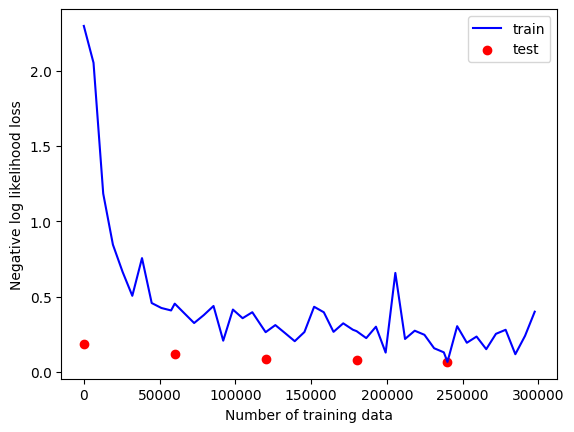

In [28]:
# 学習開始
train(num_epochs=5)

<ipython-input-104-4b5e983abbcb>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model.pth"))


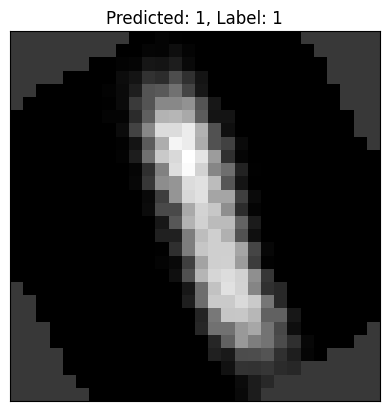

In [104]:
# ランダムに画像を選び変形して予測

import random

def evaluate():
    random_index = random.randint(0, len(test_dataset) - 1)
    data = test_dataset[random_index]

    augument_sample = torchvision.transforms.Compose([
        torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 3)),
        torchvision.transforms.RandomRotation(degrees=(0, 60)),
    ]);

    image_tensor = augument_sample(data[0])

    transform_sample = torchvision.transforms.Compose([
        torchvision.transforms.Resize((28, 28)),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ])
    transformed = transform_sample(image_tensor)
    model = Net().to(device)
    model.load_state_dict(torch.load("./model.pth"))
    model.eval()
    prediction = model(transformed.unsqueeze(0).to(device))
    image_numpy = image_tensor.squeeze().cpu().detach().numpy()

    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_numpy, cmap="gray")
    plt.title(f"Predicted: {prediction.argmax().item()}, Label: {data[1]}")

evaluate()